## Notebook for visualizing and sorting through eigenmode's purity scores

The goal is to extract canonical functional networks from Yeo et al.'s 2017 paper and compare each canonical network with our own complex Laplacian eigenmodes. 

Some methods overview:
From Basset/Betzel text: similarity between "modules" (in our case, eigen modes) and canonical cognitive systems is assessed with an overlap score: 

Let $x = [x_1,...,x_n]$ be a binary module vector whose element $x_i$ is equal to 1 if region $i$ is assigned to that module and $0$ otherwise. Similarly, let $y = [y_1,...,y_n]$ be a binary system vector whose element $y_i$ is equal to 1 if region $i$ is assigned to that system and $0$ otherwise. The overlap of $x$ and $y$ is given by $s(x,y) = \frac{x \cap y}{x \cup y}$ and the standardized version of this measure is:

$z(x,y) = \frac{s(x,y) - \mu}{\sigma}$

Where $\mu$ and $\sigma$ are the mean and standard deviation of $s(x,y)$ estimated by randomly permuting the elements of $x$ and $y$ (1000 repetitions). Large and positive values of $z(x,y)$ therefore indicate greater overlap than expected by chance, given the module's and system's sizes. For convenience, each module was assigned to the system with which it exhibited the greatest standardized overlap. 

Each "module" (eigen mode) was associated with seven overlap scores - one for each of the seven systems: $ S = [s_1, ... , s_7]$, where $s_i$ is the overlap of the "module"(eigen mode) with the $i$th system. The purity of that module quantifies the extent to which it overlaps with many systems (low purity) or few systems (high purity). "Module" (eigen mode) purity is defined by first normalizing $S$ so that its elements sum to 1. Then we compute an entropy over these elements as _purity_ $= -\sum{_i}{s'_i \log_2 s'_i}$, where $s'_i$ is the normalized overlap of a module with the $i$th system.


In [1]:
%%capture --no-display

import os
import sys
sys.path.append("../")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from nilearn import plotting
from ipywidgets import interactive, widgets, fixed

#spectrome imports:
from brain import Brain
from utils import functions, path
from forward import eigenmode, get_complex_laplacian

In [2]:
## Function for plotting with nilearn
def plot_glass_brain(fc_df, coords, fc_names):
    """ Plot transparent brain renders 
    Args:
        - color (list): Color indices
        - coords 
        - size
    Returns:
        -matplotlib object
    """
    size = fc_df.loc[fc_names].values*120
    color = [[0.1,0.1,0.6]]*86
    connectome_array = np.array([[0]*86]*86)
    plotting.plot_connectome(connectome_array, coords, node_size = size, node_color = color, display_mode = 'lyrz')
    plt.gcf().set_size_inches(12, 5)

#### Let's examine what exactly the canonical functional networks look like first.

In [3]:
# Load Pablo's Yeo 2017 region maps
com_dk = np.load('/home/axiezai/lab/brain-scfc/spectrome/spectrome/data/com_dk.npy').item()
DK_df_normalized = pd.read_csv('/home/axiezai/lab/brain-scfc/spectrome/spectrome/data/DK_dictionary_normalized.csv').set_index('Unnamed: 0')
coords = np.array([com_dk[region] for region in DK_df_normalized.columns])
# Create FC network jupyter widget for visiualization
fc_names = ['Visual','Limbic', 'Default', 'Somatomotor', 'Frontoparietal', 'Ventral_Attention', 'Dorsal_Attention']

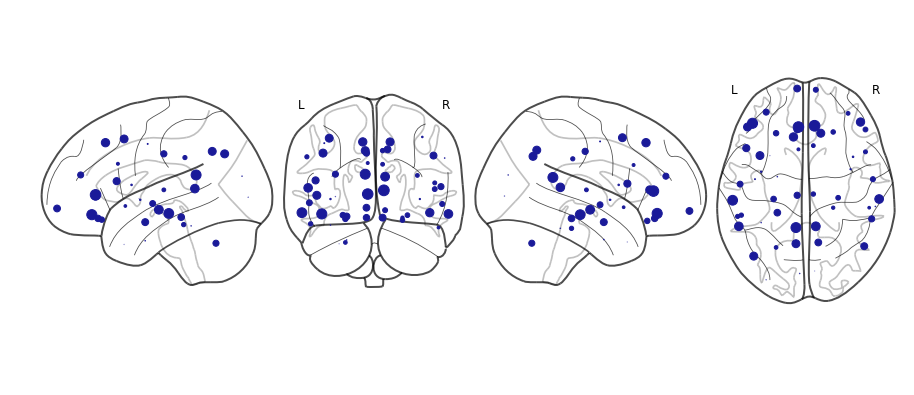

In [4]:
%%capture --no-display
%gui qt
## Post Doc Pablo Damasceno created these functional network maps from Yeo et al. 2011
#widgets don't work in lab for some reason, sticking to input to function for now:
plot_glass_brain(DK_df_normalized,coords,fc_names[2])
#interactive(plot_glass_brain, fc_df = fixed(DK_df_normalized), coords = fixed(coords), fc_names = fc_names)

#### Now we create our own Brain from spectrome, and add complex Laplacian eigenmodes to it to see if they can replicate certain canonical functional networks based on transmission speed and oscillatory frequency.

## With HCP template connectome:

In [4]:
# Brain object, get the HCP connectome and reorder.
brain = Brain.Brain() # creates empty brain object
#hcp_dir = path.get_sibling_path('data') # grabs path to data folder one folder above (sibling)
hcp_dir = "/home/axiezai/lab/brain-scfc/spectrome/spectrome/data"
brain.add_connectome(hcp_dir) # adds connectivity matrix and distance matrix to brain object

brain.reorder_connectome(brain.connectome, brain.distance_matrix)
brain.bi_symmetric_c()
brain.reduce_extreme_dir()

In [5]:
# Define frequency range of interest
fmin = 2 # 2Hz - 45Hz signal range, filter for this with hbp
fmax = 45
fvec = np.linspace(fmin,fmax,40)
# get the complex laplacian and its eigen modes:
f2w = np.abs(fvec-10).argmin() #8th index = alpha ~10hz
w = 2*np.pi*fvec[f2w]
brain.add_laplacian_eigenmodes(brain.reducedConnectome, brain.distance_matrix, w = w, speed = 10, num_ev = 25)
brain.norm_eigenmodes.shape

(86, 25)

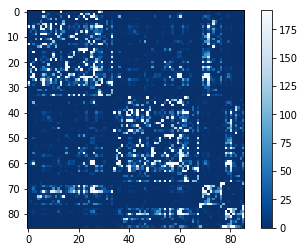

In [6]:
# visualize SC
plt.imshow(brain.reducedConnectome, cmap = plt.cm.Blues_r)
plt.colorbar()

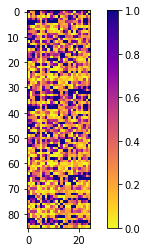

In [7]:
# visualize eigenmodes
plt.imshow(brain.norm_eigenmodes, cmap = plt.cm.plasma_r)
plt.colorbar()

## visualize some eigen modes as sanity check


In [8]:
%%capture --no-display
from surfer import Brain as surfbrain
import nibabel as nib

# set up Pysurfer variables
subject_id = "fsaverage"
hemi = "lh"
surf = "inflated"

In [9]:
"""
Bring up the visualization.
"""
#brain = Brain(subject_id, hemi , surf, background="white", views = ['lat','med'])
sbrain = surfbrain(subject_id, hemi, surf, background = "white", title = "Eigen Modes of Complex LaPlacian")
sbrain.add_text(x = 0.5, y = 0.9, text = "Eig Number , frequency = , speed = ", name = "eiglabel")

"""
Read in the automatic parcellation of sulci and gyri.
"""

hemi_side = "lh"
aparc_file = os.path.join(os.environ["SUBJECTS_DIR"],
                          subject_id, "label",
                          hemi_side + ".aparc.annot")
labels, ctab, names = nib.freesurfer.read_annot(aparc_file)

In [11]:
%gui qt
num_em = 2
# pad the eigen mode array for pysurfer
lh_eig = brain.norm_eigenmodes[0:34,num_em-1]
lh_padded_eig = np.insert(lh_eig,[0,3],[0,0])

vtx_test_brain = lh_padded_eig[labels]
sbrain.add_data(vtx_test_brain, hemi = 'lh', thresh = 0, colormap = "jet", remove_existing = True)
#brain.update_text(text = "Eig Number %s, frequency = %s, speed = %s" %(num_em, f_in, speed), name = "eiglabel")

colormap sequential: [0.00e+00, 5.00e-01, 1.00e+00] (opaque)


/home/axiezai/miniconda3/envs/spectral/lib/python3.6/site-packages/surfer/viz.py:3234: UserWarning: Data min is greater than threshold.
  warn("Data min is greater than threshold.")


#### We got our eigenmodes, now let's calculate the standardized overlap scores, then visualize the top eigenmodes with highest purity.

In [9]:
%%capture --no-display
# For each eigen vector, compute standard Z for all FC networks, then do this for all eigen vectors
df_overlap_score, df_sxy = eigenmode.get_overlap_score_dfs(brain.norm_eigenmodes, DK_df_normalized)

# normalize the standardized overlap score to be within [0,1]
norm_overlap_score = functions.minmax_scale_z(df_overlap_score)

# compute purity score for normalized standarized overlap score
z_purity, norm_overlap_score = eigenmode.get_purity_score(norm_overlap_score)
# Make it look nice in pandas dataframes:
df_cols = [('Purity Score')]
df_ind = ['Eig #%d' % x for x in np.arange(len(df_overlap_score.index))+1]
df_zpurity = pd.DataFrame(z_purity, index = df_ind, columns = df_cols)
df_norm_overlapz = pd.DataFrame(norm_overlap_score, index = df_ind, columns = df_overlap_score.columns)
# sort by descending purity value
order_index = df_zpurity.sort_values(by = 'Purity Score', ascending = False).index
ordered_overlapz = df_norm_overlapz.reindex(order_index)
ordered_zpurity = df_zpurity.reindex(order_index)
# Combine purity score with overlap score dataframe, and make it look nice
combined_df = ordered_overlapz.join(ordered_zpurity)

In [10]:
df_overlap_score.head(10)

Unnamed: 0,Default,Dorsal_Attention,Frontoparietal,Limbic,Somatomotor,Ventral_Attention,Visual
Eig #1,0.114847,0.253337,0.0449847,1,0.350266,0,0.893095
Eig #2,0.541643,0.261512,0.394089,1,0,0.251582,0.742768
Eig #3,0.290349,0,0.271805,1,0.092254,0.147332,0.549487
Eig #4,0.284335,0,0.179445,0.559246,0.967664,1,0.129187
Eig #5,1,0,0.514036,0.404632,0.516015,0.674335,0.311329
Eig #6,1,0,0.777692,0.25989,0.46457,0.434316,0.5947
Eig #7,0.503054,0,0.173142,1,0.203262,0.088502,0.51846
Eig #8,1,0.136409,0.78567,0.223333,0.341069,0.786055,0
Eig #9,0.590248,0.236166,0.278841,1,0.354309,0,0.7988
Eig #10,0.518127,0.122696,0,1,0.645198,0.342906,0.515812


In [ ]:
df_sxy.head(10).style.apply(functions.highlight_max, axis = 1)

In [ ]:
combined_df.head(10).style.set_caption('Eigen Mode Overlap & Purity Scores').apply(functions.highlight_max, subset = ordered_overlapz.columns, axis = 1)

### Non-normalized overlap DataFrame for the same sorting of purity score:

In [ ]:
%%capture --no-display
# For each eigen vector, compute standard Z for all FC networks, then do this for all eigen vectors
df_overlap_score, df_sxy = eigenmode.get_overlap_score_dfs(brain.norm_eigenmodes, DK_df_normalized)

# compute purity score for normalized standarized overlap score
z_purity, norm_overlap_score = eigenmode.get_purity_score(df_overlap_score)
# Make it look nice in pandas dataframes:
df_cols = [('Purity Score')]
df_ind = ['Eig #%d' % x for x in np.arange(len(df_overlap_score.index))+1]
df_zpurity = pd.DataFrame(z_purity, index = df_ind, columns = df_cols)
df_norm_overlapz = pd.DataFrame(norm_overlap_score, index = df_ind, columns = df_overlap_score.columns)
# sort by descending purity value
order_index = df_zpurity.sort_values(by = 'Purity Score', ascending = False).index
ordered_overlapz = df_norm_overlapz.reindex(order_index)
ordered_zpurity = df_zpurity.reindex(order_index)
# Combine purity score with overlap score dataframe, and make it look nice
combined_df = ordered_overlapz.join(ordered_zpurity)

In [ ]:
combined_df.head(10).style.set_caption('Eigen Mode Overlap & Purity Scores').apply(functions.highlight_max, subset = ordered_overlapz.columns, axis = 1)

#### What if we sort the eigenmodes by sum of purity score?

In [ ]:
overlap_score_sum = df_norm_overlapz.sum(axis = 1)
sum_cols = [('Overlap Sum')]
df_ind = ['Eig #%d' % x for x in np.arange(len(df_overlap_score.index))+1]
df_sum = pd.DataFrame(overlap_score_sum, index = df_ind, columns = sum_cols)
sum_order = df_sum.sort_values(by = 'Overlap Sum', ascending = False).index
ordered_overlapz_sum = df_norm_overlapz.reindex(sum_order)
ordered_sumdf = df_sum.reindex(sum_order)
combined_sumdf = ordered_overlapz_sum.join(ordered_sumdf)
combined_sumdf.head(10).style.set_caption('Eigen Mode Overlap Sorted By Sum').apply(functions.highlight_max, subset = ordered_overlapz.columns, axis = 1)

## To do:
 - Binary 36 subjects' eigen modes, and then compute probability map like they do in the paper.
     - First do eigen decomposition of all 36 subjects, compute overlap score for 86x36 eigenmodes, group eigenmodes by highest overlap after computing overlap score, then get top 10 overlapping eigenmodes for each functional network. Compute purity and mean(overlap) and sort for these top 10 eigenmodes.
 - Instead of overlap sum, do average(overlap) where overlap = non-normalized to between 0-1.
 - Compute p-value based on z-scores for each functional network per eigenmode from t-stat. 
 - Compute overlap/p-value the same way for alpha and beta spatial distribution - take observed alpha/beta network from 36 subjects' average to create alpha/beta network
 - repeat this for 100 HCP subjects for statistics? 

### Sorting by mean(non-normalized overlap) first:

In [ ]:
%%capture --no-display

df_overlap_score, df_sxy = eigenmode.get_overlap_score_dfs(brain.norm_eigenmodes, DK_df_normalized)
mean_overlap = df_norm_overlapz.mean(axis = 1)
sum_cols = [('mean(Overlap)')]
df_ind = ['Eig #%d' % x for x in np.arange(len(df_overlap_score.index))+1]
df_mean = pd.DataFrame(mean_overlap, index = df_ind, columns = sum_cols)
mean_order = df_mean.sort_values(by = 'mean(Overlap)', ascending = False).index
ordered_meanoverlap = df_overlap_score.reindex(mean_order)
ordered_meandf = df_mean.reindex(mean_order)
combined_meandf = ordered_meanoverlap.join(ordered_meandf)
combined_meandf.head(10).style.set_caption('Eigen Mode Overlap Sorted By Mean(Overlap)').apply(functions.highlight_max, subset = ordered_overlapz.columns, axis = 1)